In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 08 2018

@author: ncaplar@princeton.edu

"""
#%connect_info

'\nCreated on Wed Aug 08 2018\n\n@author: ncaplar@princeton.edu\n\n'

This cell below contains some extensions that I use that make life much easier when using jupyter notebook 
These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

In [2]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}



<IPython.core.display.Javascript object>

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
#import statments
from __future__ import absolute_import, division, print_function
import numpy as np
import pandas as pd
import io
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 22})
%config InlineBackend.rc = {}
%matplotlib inline

# Theoretical Analysis 

## import of auto-correlation function (ACF) files

In [5]:
# load precomputed table of autocorrelation functions generated in Wolfram Mathematica notebook
ACFData=np.loadtxt(open('/Users/nevencaplar/Documents/Variability/MainSequence/Github/ACFTableFlatten.csv', "rb"), delimiter=",", skiprows=0)
ACFData[:,1]=np.round(ACFData[:,1],2)
#ACFData=ACFData[np.lexsort((ACFData[:,0], ACFData[:,1],ACFData[:,2]))]

These auto-correlation function have been computed numerically in Wolfram Mathematica (notebook also avaliable in the Github folder) for PSD=1/(1+(f/f_bend)^(slope)),
where tau=1/f_bend and f is frequency.

They are tabulated as function of tau (decorrelation time), slope(high frequency slope of the PSD) and time.

In [6]:
tau=np.unique(ACFData[:,0])
slope=np.unique(ACFData[:,1])
time=np.unique(ACFData[:,2])
ACF=ACFData[:,3]

print('avaliable tau are: '+str(tau))
print('avaliable slopes are: '+str(slope))
print('largest avaliable time is: '+str(max(time)))

avaliable tau are: [   1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   20.   30.
   40.   50.   60.   70.   80.   90.  100.  110.  120.  130.  140.  150.
  160.  170.  180.  190.  200.]
avaliable slopes are: [ 0.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4
  2.5  2.6  2.7  2.8  2.9]
largest avaliable time is: 1000.0


In [7]:
# constructing multi-index panda dataframe (series)
mi = pd.MultiIndex.from_product([tau, slope, time], names=['tau', 'slope', 'time'])

#connect multiindex to data and save as multindexed series
sr_multi = pd.Series(index=mi, data=ACF.flatten())

## Looking at ACF

In [8]:
def get_ACF(tau,slope):
    """!gives autocorrelation function as a 2d numpy array [time, ACF]

    @param[in] tau          Decorrelation time
    @param[in] slope        high frequency slope of the PSD



    """
    
    #pull out a dataframe with tau = 100 time units (see all options above)
    select_tau=sr_multi.xs(tau, level='tau').unstack(level=0)
    #pull out a dataframe with slope = 2
    select_tau_and_slope=select_tau[slope]
    
    res=[]
    for j in range(1,len(select_tau_and_slope.values)):
        res.append([j,select_tau_and_slope.values[j]])
    
    res=np.array(res)
    return res

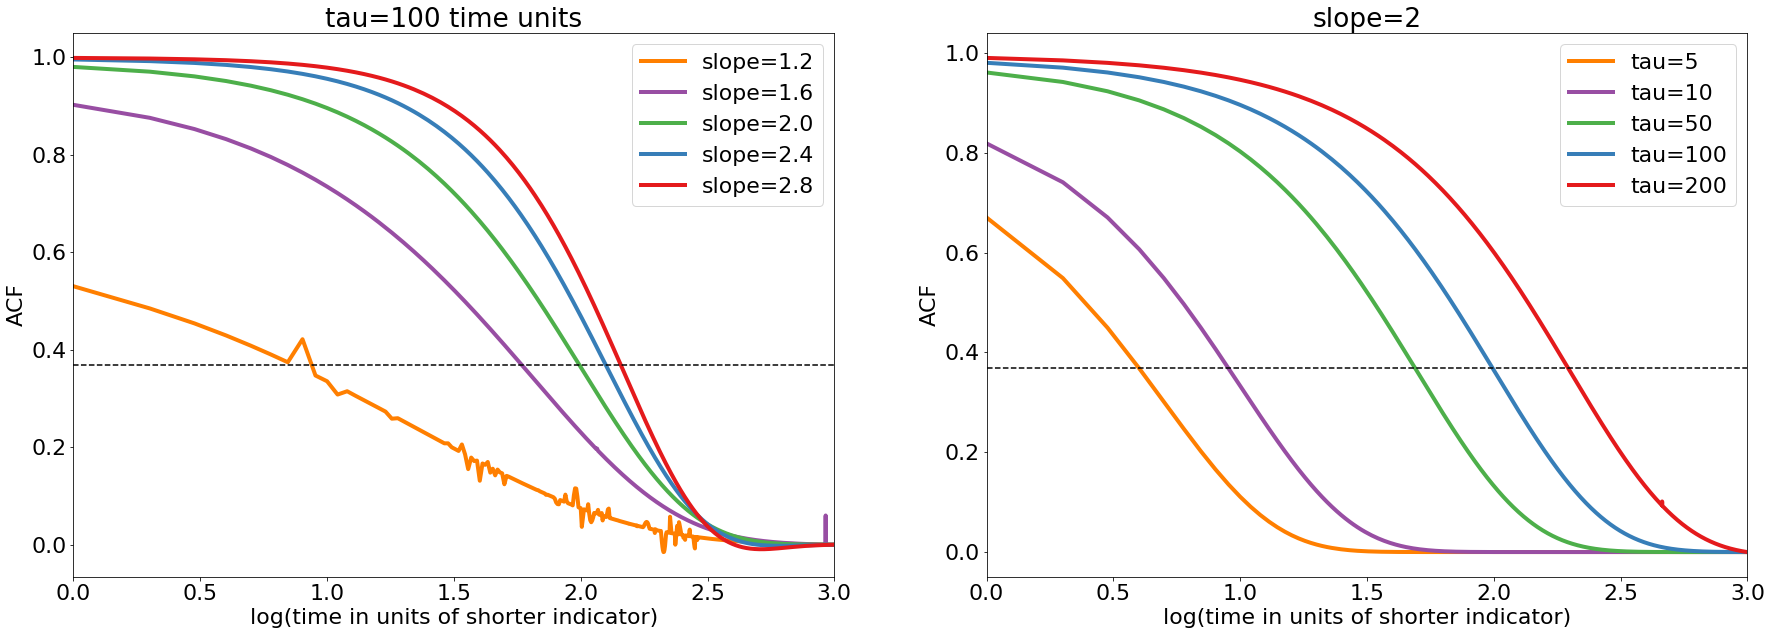

In [19]:
"""
Example showing how ACF depend on slope and tau
For slope 2 (damped random walk) we know the exact result that ACF(t)=exp(-t/tau)
We can verify below that ACF(100)=1/exp(-1) for the case of slope=2

colors from colorbrewer2.org

One can also notice numerical instabilities in the numerical integration for shallow slopes
"""
plot_slope=2
plot_tau=100


plt.figure(figsize=(30,10))

plt.subplot(121)

ACF_Example1=get_ACF(plot_tau,1.2)
ACF_Example2=get_ACF(plot_tau,1.6)
ACF_Example3=get_ACF(plot_tau,2)
ACF_Example4=get_ACF(plot_tau,2.4)
ACF_Example5=get_ACF(plot_tau,2.8)

plt.plot(np.log10(ACF_Example1[:,0]),ACF_Example1[:,1],color='#ff7f00',label='slope=1.2',lw=4,linestyle='-')
plt.plot(np.log10(ACF_Example2[:,0]),ACF_Example2[:,1],color='#984ea3',label='slope=1.6',lw=4)
plt.plot(np.log10(ACF_Example3[:,0]),ACF_Example3[:,1],color='#4daf4a',label='slope=2.0',lw=4)
plt.plot(np.log10(ACF_Example4[:,0]),ACF_Example4[:,1],color='#377eb8',label='slope=2.4',lw=4)
plt.plot(np.log10(ACF_Example5[:,0]),ACF_Example5[:,1],color='#e41a1c',label='slope=2.8',lw=4)

plt.plot(np.array(range(10)),np.full((10),1/np.exp(1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of shorter indicator)')
plt.ylabel('ACF')
plt.title('tau='+str(plot_tau)+' time units')
plt.legend(fontsize=22)


plt.subplot(122)
ACF_Example1=get_ACF(5,plot_slope)
ACF_Example2=get_ACF(10,plot_slope)
ACF_Example3=get_ACF(50,plot_slope)
ACF_Example4=get_ACF(100,plot_slope)
ACF_Example5=get_ACF(200,plot_slope)

plt.plot(np.log10(ACF_Example1[:,0]),ACF_Example1[:,1],color='#ff7f00',label='tau=5',lw=4,linestyle='-')
plt.plot(np.log10(ACF_Example2[:,0]),ACF_Example2[:,1],color='#984ea3',label='tau=10',lw=4)
plt.plot(np.log10(ACF_Example3[:,0]),ACF_Example3[:,1],color='#4daf4a',label='tau=50',lw=4)
plt.plot(np.log10(ACF_Example4[:,0]),ACF_Example4[:,1],color='#377eb8',label='tau=100',lw=4)
plt.plot(np.log10(ACF_Example5[:,0]),ACF_Example5[:,1],color='#e41a1c',label='tau=200',lw=4)

plt.plot(np.array(range(10)),np.full((10),1/np.exp(1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of shorter indicator)')
plt.ylabel('ACF')
plt.title('slope='+str(plot_slope))
plt.legend(fontsize=22)

## Scatter of the main sequence with indicator measuring longer time scales

Given the scatter of the main sequence measured by a shorter time indicator (e.g., H_alpha) scatter of the main sequence measured by a longer time indicator (e.g., UV) will be given by relation:


$\sigma_{longer}=\frac{\sigma_{shorter}}{\sqrt{N}} \left(1 + 2 \sum^{N}_{j=1} \left(1-\frac{j}{N} \right)ACF(j)  \right)^{1/2} $ 

where N is numer of times than the longer time indicator is lager (longer) than the short time indicator. (relation derived below, but also see e.g., Ivezic, Connolly, VanderPlas and Gray, 2014 Equation (10.93); or Priestley 1981, Equation (5.3.5))

Let's consider observations of offset from main sequence with shorter time indicator in $N_{i}$ objects at $N{j}$ different times. Let's denote different galaxies with $i$ and different times with $j$. For each individual object offset from MS in a longer indicator is just an average of offsets, i.e., $\Delta SFR(i)_{longer}=\frac{1}{N_{j}} \sum^{N_{j}}_{j=1} \Delta SFR_{shorter}(i,j)$. Scatter of main sequence as measured by a longer indicator is just standard deviation of the distribution of $\Delta SFR(i)_{longer}$. We are therefore interested in $VAR( \Delta SFR_{longer})=VAR\left( \frac{1}{N_{j}} \sum^{N_{j}}_{j=1} SFR_{shorter}(j)\right)$. Then  using Priestley 1981, Equation (2.13.15): $VAR(\Delta SFR_{longer})=\frac{1}{N^{2}_{j}}\sum^{N_{j}}_{j=1} \sum^{N_{j}}_{j^{'}=1} \sigma_{j j^{'}} = \frac{\sigma^{2}_{shorter}}{N^{2}_{j}}\sum^{N_{j}}_{j=1} \sum^{N_{j}}_{j^{'}=1} ACF(j-j^{'}) $, where we have used the definition of ACF to make substitute $\sigma_{jj^{'}}=\sigma^{2}_{shorter} ACF(j-j^{'})$. Discussion below Equation Equation (5.3.4) in Priestley 1981 explains how this double sum can be simplifed using the fact that the summand only depends on $(j-j^{'})$ to get $VAR(\Delta SFR_{longer})= \frac{\sigma^{2}_{shorter}}{N} \sum^{N_{j}-1}_{r=-(N_{j}-1)} \left( 1- \frac{|r|}{N_{j}} \right)ACF(r)$ where $r=j-j^{'}$. After taking square root, simplifying the sum and changing $N{j}->N$ and $r->j$ we get the starting equation above.


In [9]:
def get_scatter_MS(tau,slope,tMax=None):
    """!gives size of scatter as a 2d numpy array [time, scatter]

    @param[in] tau          Decorellation time
    @param[in] slope        high frequency slope of the PSD
    @param[in] tmax         what is the largest time that you want to consider (see 'largest avaliable time is' above);


    """
    if tMax is None:
        tMax=int(max(time))
    
    ACF=get_ACF(tau,slope)
    
    res=[]
    for t in range(1,tMax):
        res.append([t,(1+2*np.sum(((1-np.array(range(1,t+1))/t))*ACF[:,1][:t]))**(1/2)*(1/(t**(1/2)))])

    res=np.array(res)
    return res

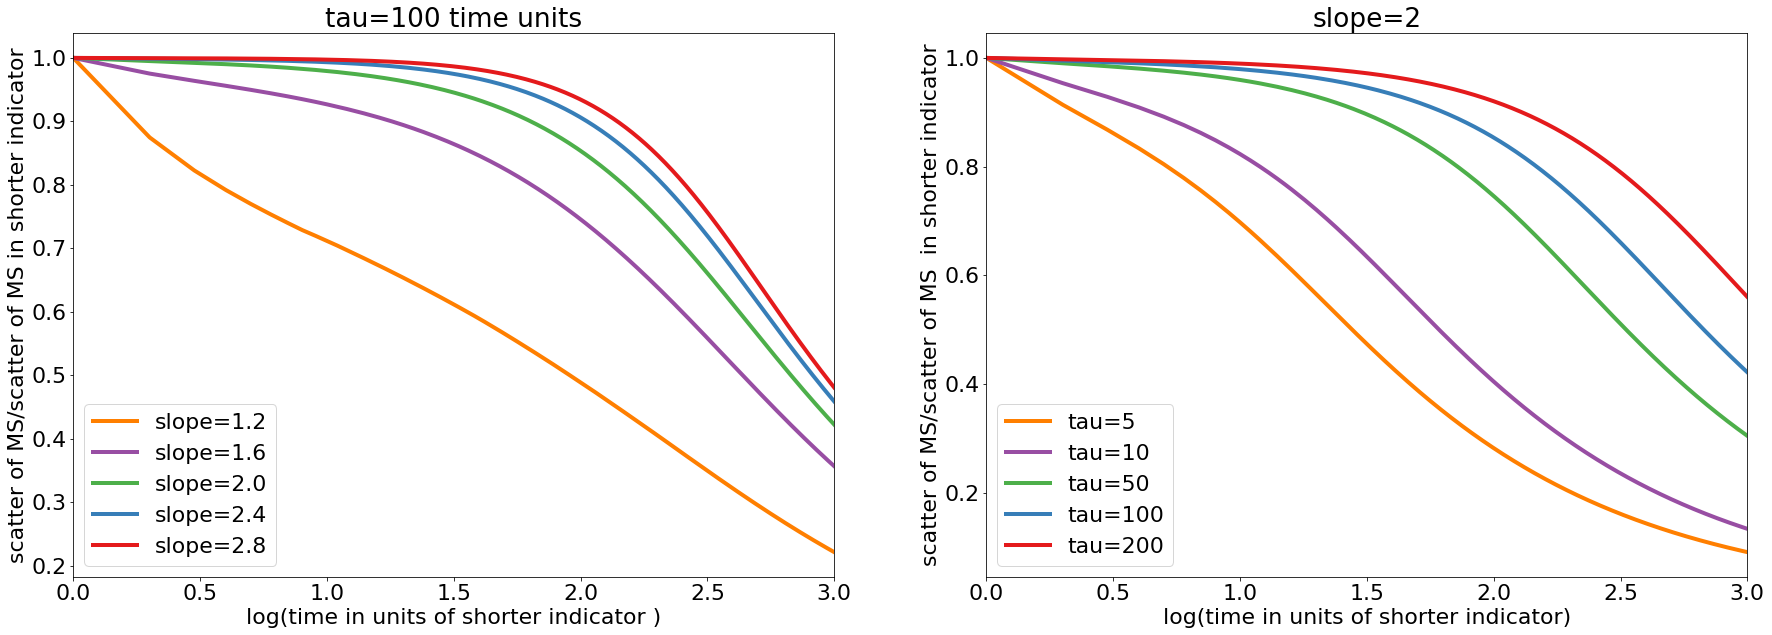

In [21]:
"""
Example showing how scatter depend on slope and tau 
"""
plot_slope=2
plot_tau=100


plt.figure(figsize=(30,10))

plt.subplot(121)

Scatter_Example1=get_scatter_MS(plot_tau,1.2)
Scatter_Example2=get_scatter_MS(plot_tau,1.6)
Scatter_Example3=get_scatter_MS(plot_tau,2)
Scatter_Example4=get_scatter_MS(plot_tau,2.4)
Scatter_Example5=get_scatter_MS(plot_tau,2.8)

plt.plot(np.log10(Scatter_Example1[:,0]),Scatter_Example1[:,1],color='#ff7f00',label='slope=1.2',lw=4,linestyle='-')
plt.plot(np.log10(Scatter_Example2[:,0]),Scatter_Example2[:,1],color='#984ea3',label='slope=1.6',lw=4)
plt.plot(np.log10(Scatter_Example3[:,0]),Scatter_Example3[:,1],color='#4daf4a',label='slope=2.0',lw=4)
plt.plot(np.log10(Scatter_Example4[:,0]),Scatter_Example4[:,1],color='#377eb8',label='slope=2.4',lw=4)
plt.plot(np.log10(Scatter_Example5[:,0]),Scatter_Example5[:,1],color='#e41a1c',label='slope=2.8',lw=4)

#plt.plot(np.array(range(10)),np.full((10),1/np.exp(1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of shorter indicator )')
plt.ylabel('scatter of MS/scatter of MS in shorter indicator')
plt.title('tau='+str(plot_tau)+' time units')
plt.legend(fontsize=22)



plt.subplot(122)
Scatter_Example1=get_scatter_MS(5,plot_slope)
Scatter_Example2=get_scatter_MS(10,plot_slope)
Scatter_Example3=get_scatter_MS(50,plot_slope)
Scatter_Example4=get_scatter_MS(100,plot_slope)
Scatter_Example5=get_scatter_MS(200,plot_slope)

plt.plot(np.log10(Scatter_Example1[:,0]),Scatter_Example1[:,1],color='#ff7f00',label='tau=5',lw=4,linestyle='-')
plt.plot(np.log10(Scatter_Example2[:,0]),Scatter_Example2[:,1],color='#984ea3',label='tau=10',lw=4)
plt.plot(np.log10(Scatter_Example3[:,0]),Scatter_Example3[:,1],color='#4daf4a',label='tau=50',lw=4)
plt.plot(np.log10(Scatter_Example4[:,0]),Scatter_Example4[:,1],color='#377eb8',label='tau=100',lw=4)
plt.plot(np.log10(Scatter_Example5[:,0]),Scatter_Example5[:,1],color='#e41a1c',label='tau=200',lw=4)

#plt.plot(np.array(range(10)),np.full((10),1/np.exp(1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of shorter indicator)')
plt.ylabel('scatter of MS/scatter of MS  in shorter indicator')
plt.title('slope='+str(plot_slope))
plt.legend(fontsize=22)

## Mean relation between indicators at longer and shorter time scales

Given the measurment of the offset from the main sequence measured in a shorter time indicator (e.g., H_alpha),  offset from the main sequence of the same object measured by a longer time indicator (e.g., UV) will be given by relation:

$ \Delta SFR_{longer}=\Delta SFR_{shorter} \cdot \frac{1}{N} \sum^{N}_{j=1} ACF(j) $  

where N is numer of times than the longer time indicator is lager (longer) than the short time indicator. This can be "easily" seen once when we realize $\Delta  SFR_{shorter} (j) =\Delta  SFR_{shorter} (j^{'}) \cdot ACF(j-j^{'})   $ and combine with  $ \Delta SFR_{longer}= \sum^{N}_{j=1} \Delta SFR_{shorter}(j)$




For exact case of damped random walk where we know that $ACF(j)=\exp(-j/\tau)$, where $\tau$ is decorrelation time, we can evaluate the sum explicity to get: 

$\Delta SFR_{longer}=\Delta SFR_{shorter}  \left(- \frac{\exp(1/\tau)-\exp(-N/\tau)}{N(1- \exp(1/\tau))} \right) $

In [10]:
def get_scatter_MS(tau,slope,tMax=None,t_avg=None):
    """!gives size of scatter as a 2d numpy array [time, scatter]

    @param[in] tau          Decorellation time
    @param[in] slope        high frequency slope of the PSD
    @param[in] tmax         what is the largest time that you want to consider (see 'largest avaliable time is' above);


    """
    if tMax is None:
        tMax=int(max(time))
    
    ACF=get_ACF(tau,slope)
    
    res=[]
    for t in range(1,tMax):
        res.append([t,(1+2*np.sum(((1-np.array(range(1,t+1))/t))*ACF[:,1][:t]))**(1/2)*(1/(t**(1/2)))])
        
    res=np.array(res)
    if t_avg is None:
        return res
    else:
        assert t_avg<tMax
        return res[int(t_avg-1)]   

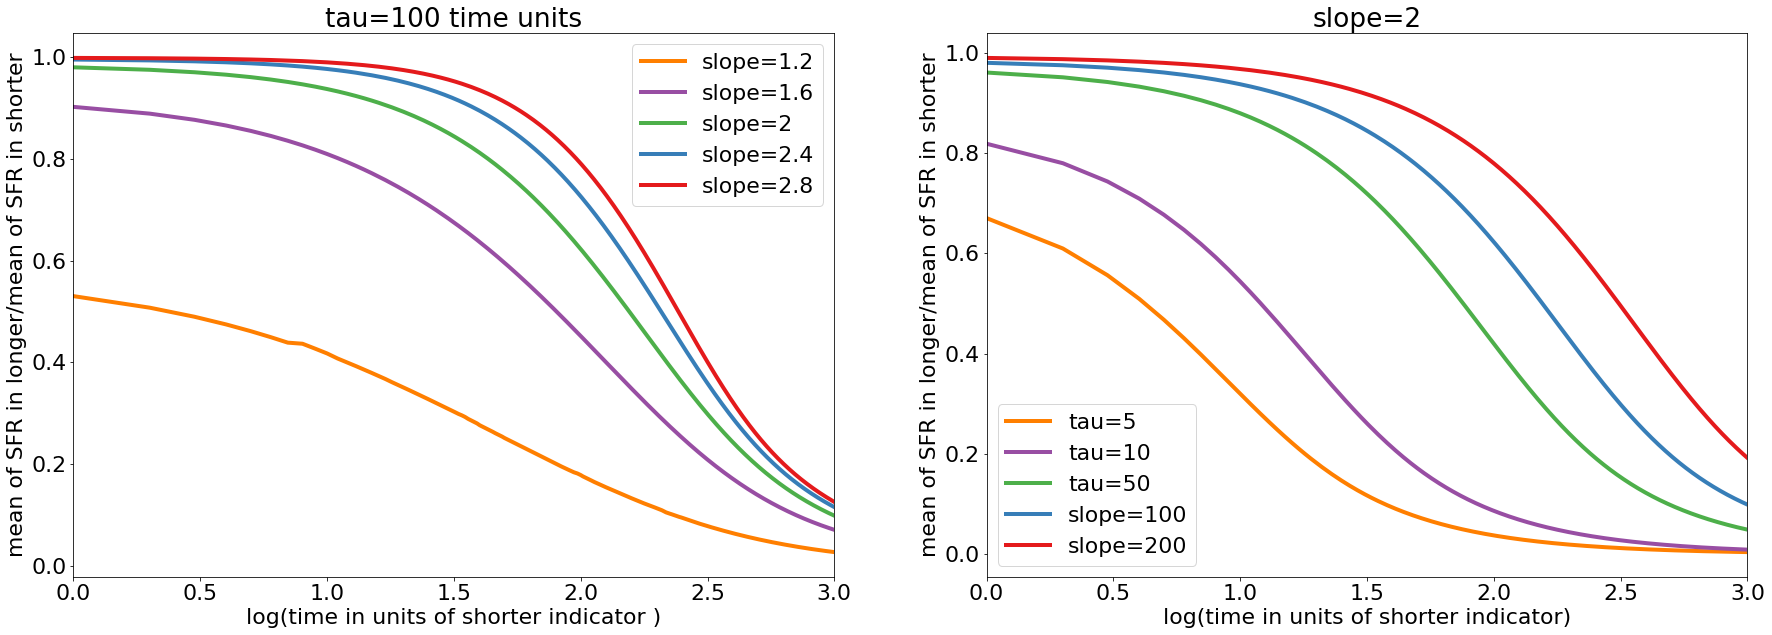

In [23]:
"""
Example showing how mean depend on slope and tau 
"""
plt.figure(figsize=(30,10))

plot_slope=2
plot_tau=100

plt.subplot(121)

Mean_Example1=get_mean_relation(plot_tau,1.2)
Mean_Example2=get_mean_relation(plot_tau,1.6)
Mean_Example3=get_mean_relation(plot_tau,2)
Mean_Example4=get_mean_relation(plot_tau,2.4)
Mean_Example5=get_mean_relation(plot_tau,2.8)

plt.plot(np.log10(Mean_Example1[:,0]),Mean_Example1[:,1],color='#ff7f00',label='slope=1.2',lw=4,linestyle='-')
plt.plot(np.log10(Mean_Example2[:,0]),Mean_Example2[:,1],color='#984ea3',label='slope=1.6',lw=4,)
plt.plot(np.log10(Mean_Example3[:,0]),Mean_Example3[:,1],color='#4daf4a',label='slope=2',lw=4,)
plt.plot(np.log10(Mean_Example4[:,0]),Mean_Example4[:,1],color='#377eb8',label='slope=2.4',lw=4,)
plt.plot(np.log10(Mean_Example5[:,0]),Mean_Example5[:,1],color='#e41a1c',label='slope=2.8',lw=4,)
#plt.plot(np.array(range(10)),np.full((10),1/np.exp(1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of shorter indicator )')
plt.ylabel('mean of SFR in longer/mean of SFR in shorter')
plt.title('tau='+str(plot_tau)+' time units')
plt.legend(fontsize=22)


plt.subplot(122)
Mean_Example1=get_mean_relation(5,plot_slope)
Mean_Example2=get_mean_relation(10,plot_slope)
Mean_Example3=get_mean_relation(50,plot_slope)
Mean_Example4=get_mean_relation(100,plot_slope)
Mean_Example5=get_mean_relation(200,plot_slope)

plt.plot(np.log10(Mean_Example1[:,0]),Mean_Example1[:,1],color='#ff7f00',label='tau=5',lw=4,linestyle='-')
plt.plot(np.log10(Mean_Example2[:,0]),Mean_Example2[:,1],color='#984ea3',label='tau=10',lw=4,)
plt.plot(np.log10(Mean_Example3[:,0]),Mean_Example3[:,1],color='#4daf4a',label='tau=50',lw=4,)
plt.plot(np.log10(Mean_Example4[:,0]),Mean_Example4[:,1],color='#377eb8',label='slope=100',lw=4,)
plt.plot(np.log10(Mean_Example5[:,0]),Mean_Example5[:,1],color='#e41a1c',label='slope=200',lw=4,)

#plt.plot(np.array(range(10)),np.full((10),1/np.exp(1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of shorter indicator)')
plt.ylabel('mean of SFR in longer/mean of SFR in shorter')
plt.title('slope='+str(plot_slope))
plt.legend(fontsize=22)

## error of Delta SFR_longer at given Delta SFR_shorter

There is also information in the size of the scatter in $\Delta SFR_{longer}$ at a given  $\Delta SFR_{shorter}$ and vice versa (this quantity is denoted by the size of the yellow 'error' bars in the example figures below). Problem with using this information is that:
    1. Very difficult to observe 
    2. depends on the size of the bins and 
    3. depends on how step the relation betweem SFR at longer and shorer time scale is

Given those problems and that this is very similar information which is encapsulated in measuring scatter of MS we do not use this information, but we give relation below:

$\sigma_{longer}|_{\mbox{given shorter}}=\frac{\sigma_{shorter}}{\sqrt{N}} \left( \sum^{N}_{j=1} \sum^{N}_{j^{'}=1} ACF(j-j^{'}) (1-ACF(j))^{1/2} (1-ACF(j^{'}))^{1/2} \right)^{1/2} $ 

This realation can note be simlified further as the relation for scatter in section 1.2 could, as the summand now is not a function of only $j-j^{'}$.

# Examples with simulated data

Below we show few example with generated SFR history curves and show that our theoretical predictions match what is seen in generated data. We use (very) losely $H_{\alpha}$ as a name shorter time indicator and UV as a name for longer time indicator.

In [25]:
from DELCgen import *

## With the same slope, different tau

In [46]:
# amplitude
A=1
#slope on the short time scales
a_low=2.0
#slope on the long time scales
a_high=0
# intercept/offset: adds constant to the final output
c=10

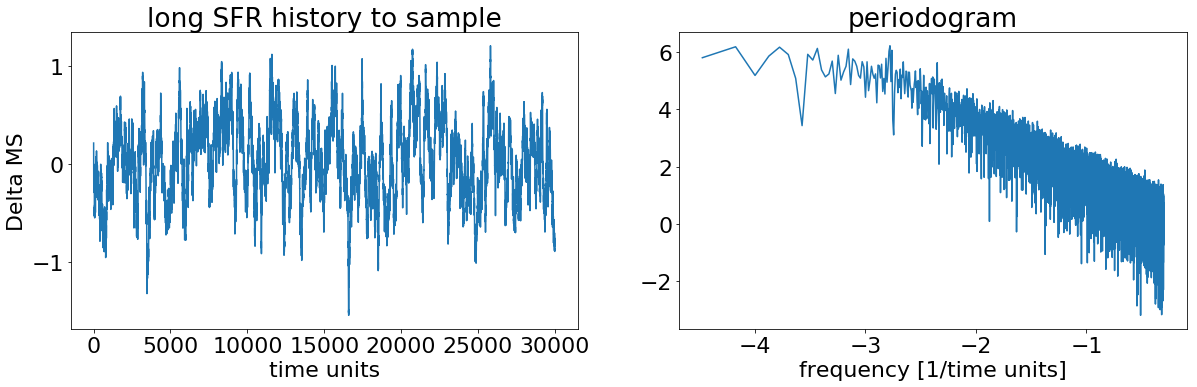

In [52]:
# keep RedNoiseL at least at 10, perhaps 5 if it gets really slow
# Keep aliasTbin=1 


#frequency of the break
v_bend_Example1=1.0/( 20*2*np.pi)
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend_Example1,a_low,a_high,0),RedNoiseL=10,aliasTbin=1,tbin = 1,length=30000)
#Set scatter of the Main Sequence at 0.4 dex in this example
delc_flux_Example1=0.4*delc.flux

#frequency of the break
v_bend_Example2=1.0/(100*2*np.pi)
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend_Example2,a_low,a_high,0),RedNoiseL=10,aliasTbin=1,tbin = 1,length=30000)
delc_flux_Example2=0.4*delc.flux

#frequency of the break
v_bend_Example3=1.0/( 200*2*np.pi)
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend_Example3,a_low,a_high,0),RedNoiseL=10,aliasTbin=1,tbin = 1,length=30000)
delc_flux_Example3=0.4*delc.flux

# Plot showing created movement around Main Sequence and the periodogram 
plt.figure(figsize=(20,12))
plt.subplot(221)
plt.plot(0.4*delc.flux)
plt.title('long SFR history to sample')
plt.xlabel('time units')
plt.ylabel('Delta MS')

plt.subplot(222)
plt.plot(np.log10(delc.periodogram[0]),np.log10(delc.periodogram[1]))
plt.title('periodogram')
plt.xlabel('frequency [1/time units]')

In [53]:
# We use here 'SFR_Halpha' as SFR measured on shorter time scale
# and 'SFR_UV' as SFR measured on longer time scale
# Tmax = answer to the question :How much longer is 'SFR_UV' then 'SFR_Halpha'?
Tmax=100

#generate 'data'
res_Example1=[]
res_Example2=[]
res_Example3=[]
random_start_positions=np.random.randint(0,30000-Tmax,10000)
for i in range(len(random_start_positions)):
    res_Example1.append([delc_flux_Example1[random_start_positions[i]+Tmax],np.mean(delc_flux_Example1[random_start_positions[i]:random_start_positions[i]+Tmax])])
    res_Example2.append([delc_flux_Example2[random_start_positions[i]+Tmax],np.mean(delc_flux_Example2[random_start_positions[i]:random_start_positions[i]+Tmax])])
    res_Example3.append([delc_flux_Example3[random_start_positions[i]+Tmax],np.mean(delc_flux_Example3[random_start_positions[i]:random_start_positions[i]+Tmax])])
   
res_Example1=np.array(res_Example1)    
res_Example2=np.array(res_Example2)    
res_Example3=np.array(res_Example3)  

In [54]:
# estimate mean relation between 'SFR_UV' and 'SFR_Halpha'

SFR_SFR_Example1=[]
SFR_SFR_Example2=[]
SFR_SFR_Example3=[]
for i in np.arange(-1,1,0.05):
    res_Example1_bin=res_Example1[np.all([res_Example1[:,0]<i+0.05, res_Example1[:,0]>i],axis=0)]
    SFR_SFR_Example1.append([np.mean(res_Example1_bin[:,0]),np.mean(res_Example1_bin[:,1]),np.std(res_Example1_bin[:,1])])
    res_Example2_bin=res_Example2[np.all([res_Example2[:,0]<i+0.05, res_Example2[:,0]>i],axis=0)]
    SFR_SFR_Example2.append([np.mean(res_Example2_bin[:,0]),np.mean(res_Example2_bin[:,1]),np.std(res_Example2_bin[:,1])])
    res_Example3_bin=res_Example3[np.all([res_Example3[:,0]<i+0.01, res_Example3[:,0]>i],axis=0)]
    SFR_SFR_Example3.append([np.mean(res_Example3_bin[:,0]),np.mean(res_Example3_bin[:,1]),np.std(res_Example3_bin[:,1])])
    
SFR_SFR_Example1=np.array(SFR_SFR_Example1)
SFR_SFR_Example2=np.array(SFR_SFR_Example2)
SFR_SFR_Example3=np.array(SFR_SFR_Example3)

In [55]:
# theoretical mean relation between 'SFR_UV' and 'SFR_Halpha'

tau_Example1=(1/v_bend_Example1)/(2*np.pi)
SFR_UV_Theoretical_Example1=[]
for SFR_Halpha in np.arange(-1,1,0.01):
    SFR_UV_Theoretical_Example1.append([SFR_Halpha,SFR_Halpha*get_mean_relation(tau_Example1,a_low)[Tmax-1][1]])
SFR_UV_Theoretical_Example1=np.array(SFR_UV_Theoretical_Example1)

tau_Example2=(1/v_bend_Example2)/(2*np.pi)
SFR_UV_Theoretical_Example2=[]
for SFR_Halpha in np.arange(-1,1,0.01):
    SFR_UV_Theoretical_Example2.append([SFR_Halpha,SFR_Halpha*get_mean_relation(tau_Example2,a_low)[Tmax-1][1]])
SFR_UV_Theoretical_Example2=np.array(SFR_UV_Theoretical_Example2)

tau_Example3=(1/v_bend_Example3)/(2*np.pi)
SFR_UV_Theoretical_Example3=[]
for SFR_Halpha in np.arange(-1,1,0.01):
    SFR_UV_Theoretical_Example3.append([SFR_Halpha,SFR_Halpha*get_mean_relation(tau_Example3,a_low)[Tmax-1][1]])
SFR_UV_Theoretical_Example3=np.array(SFR_UV_Theoretical_Example3)

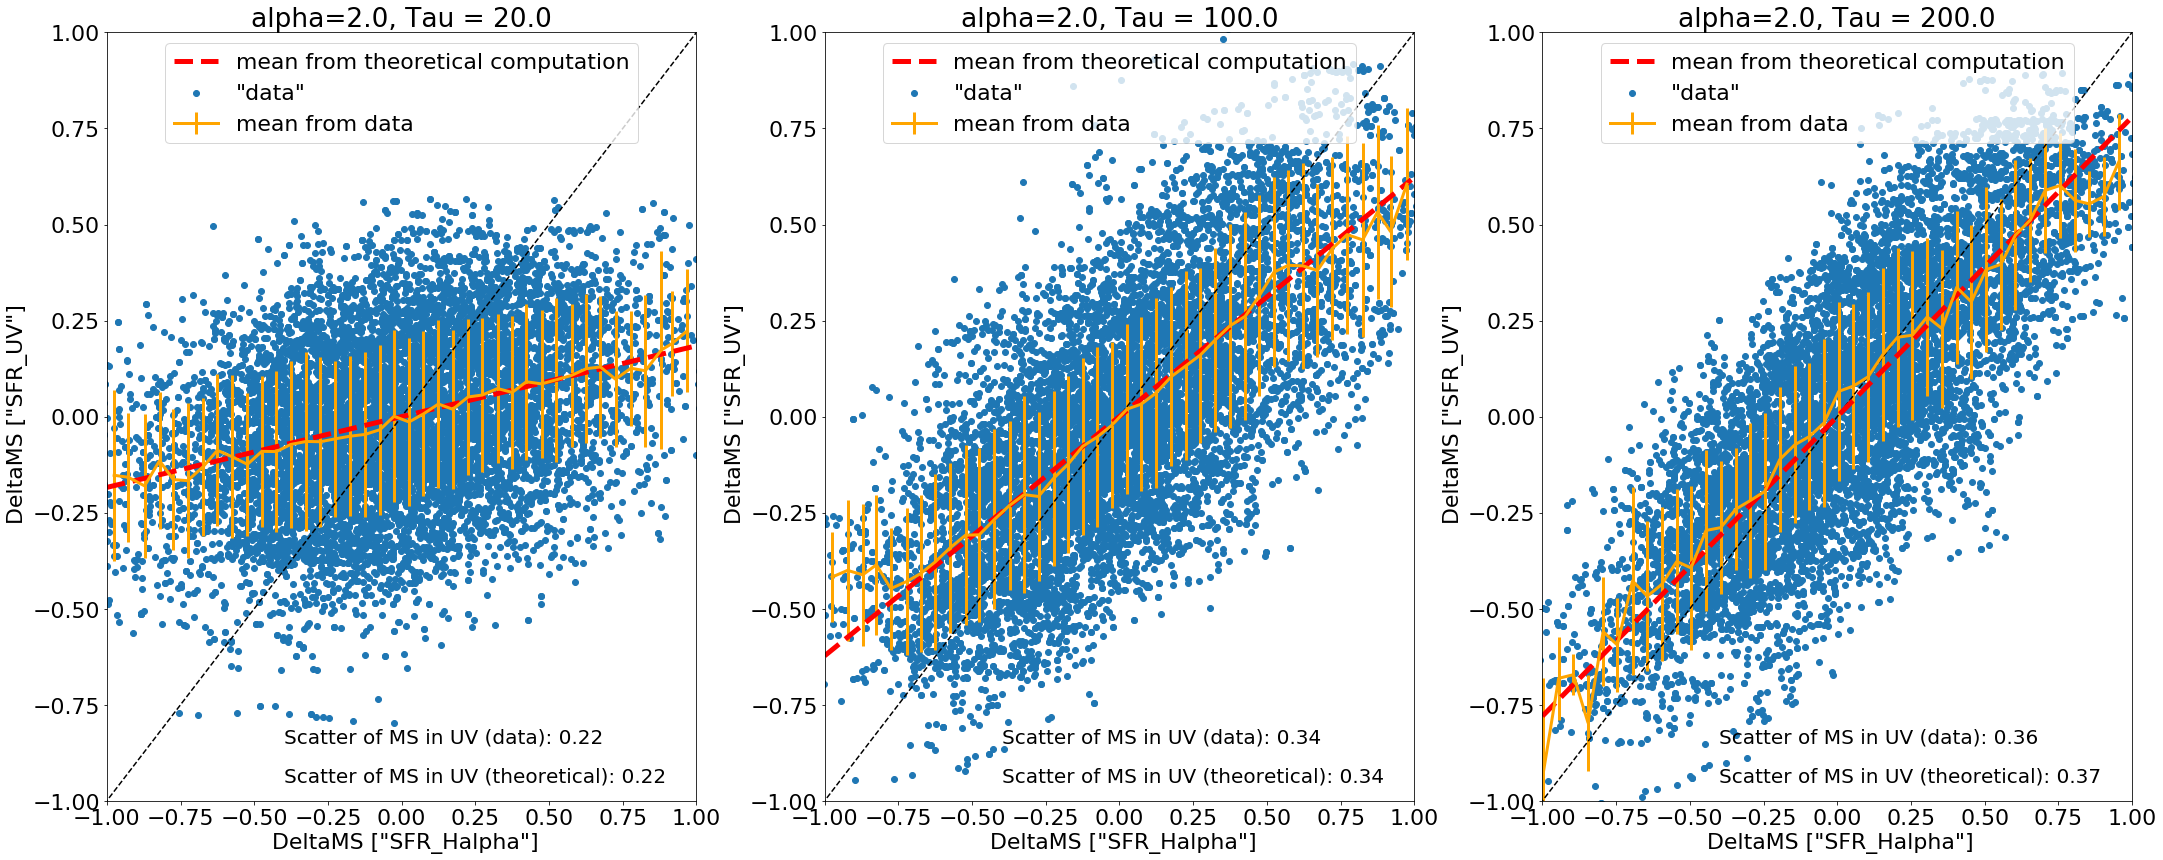

In [56]:
plt.figure(figsize=(30,12))

plt.subplot(1,3,1)
plt.scatter(res_Example1[:,0],res_Example1[:,1],label='"data"')
plt.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')
plt.xlabel(' DeltaMS ["SFR_Halpha"]')
plt.ylabel(' DeltaMS ["SFR_UV"]')
plt.errorbar(SFR_SFR_Example1[:,0],SFR_SFR_Example1[:,1],yerr=SFR_SFR_Example1[:,2],color='orange',lw=3,label='mean from data')
plt.plot(SFR_UV_Theoretical_Example1[:,0],SFR_UV_Theoretical_Example1[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
plt.legend(loc='upper center')
plt.title("alpha="+str(a_low)+", Tau = "+str(tau_Example1))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example1[:,1]),2),{'color': 'black', 'fontsize': 20})
plt.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau_Example1,a_low)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})

plt.subplot(1,3,2)
plt.scatter(res_Example2[:,0],res_Example2[:,1],label='"data"')
plt.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')
plt.xlabel(' DeltaMS ["SFR_Halpha"]')
plt.ylabel(' DeltaMS ["SFR_UV"]')
plt.errorbar(SFR_SFR_Example2[:,0],SFR_SFR_Example2[:,1],yerr=SFR_SFR_Example2[:,2],color='orange',lw=3,label='mean from data')
plt.plot(SFR_UV_Theoretical_Example2[:,0],SFR_UV_Theoretical_Example2[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
plt.legend(loc='upper center')
plt.title("alpha="+str(a_low)+", Tau = "+str(tau_Example2))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example2[:,1]),2),{'color': 'black', 'fontsize': 20})
plt.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau_Example2,a_low)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})


plt.subplot(1,3,3)
plt.scatter(res_Example3[:,0],res_Example3[:,1],label='"data"')
plt.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')
plt.xlabel(' DeltaMS ["SFR_Halpha"]')
plt.ylabel(' DeltaMS ["SFR_UV"]')
plt.errorbar(SFR_SFR_Example3[:,0],SFR_SFR_Example3[:,1],yerr=SFR_SFR_Example3[:,2],color='orange',lw=3,label='mean from data')
plt.plot(SFR_UV_Theoretical_Example3[:,0],SFR_UV_Theoretical_Example3[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
plt.legend(loc='upper center')
plt.title("alpha="+str(a_low)+", Tau = "+str(tau_Example3))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example3[:,1]),2),{'color': 'black', 'fontsize': 20})
plt.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau_Example3,a_low)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})


plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [57]:
print(np.median(SFR_SFR_Example1[:,2][int((len(SFR_SFR_Example1[:,2])/2)-5):(int(len(SFR_SFR_Example1[:,2])/2)+5)]))
print(np.median(SFR_SFR_Example2[:,2][int((len(SFR_SFR_Example1[:,2])/2)-5):(int(len(SFR_SFR_Example1[:,2])/2)+5)]))
print(np.median(SFR_SFR_Example3[:,2][int((len(SFR_SFR_Example1[:,2])/2)-5):(int(len(SFR_SFR_Example1[:,2])/2)+5)]))

0.215266401603
0.229711426049
0.216073569136


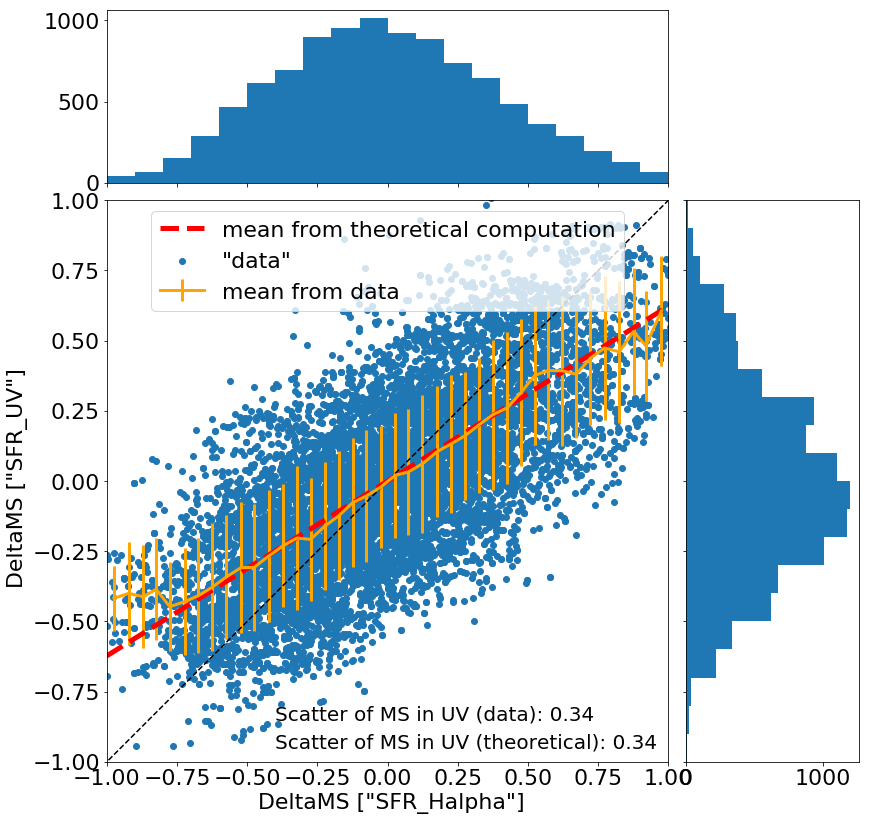

In [58]:
#single plot showing explicity difference in scatter for the middle panel in the Figure above

from matplotlib.ticker import NullFormatter

plt.figure(figsize=(12,12))

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(NullFormatter() )
axHisty.yaxis.set_major_formatter(NullFormatter() )

x=res_Example2[:,0]
y=res_Example2[:,1]

axScatter.scatter(res_Example2[:,0],res_Example2[:,1],label='"data"')
axScatter.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')

axScatter.set_xlabel(' DeltaMS ["SFR_Halpha"]')
axScatter.set_ylabel(' DeltaMS ["SFR_UV"]')
axScatter.errorbar(SFR_SFR_Example2[:,0],SFR_SFR_Example2[:,1],yerr=SFR_SFR_Example2[:,2],color='orange',lw=3,label='mean from data')
axScatter.plot(SFR_UV_Theoretical_Example2[:,0],SFR_UV_Theoretical_Example2[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
axScatter.legend(loc='upper center')
#axScatter.title("alpha="+str(a_low)+", Tau = "+str(tau_Example2))
axScatter.set_xlim([-1,1])
axScatter.set_ylim(-1,1)
axScatter.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example2[:,1]),2),{'color': 'black', 'fontsize': 20})
axScatter.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau_Example2,a_low)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})


# now determine nice limits by hand:
binwidth = 0.1
xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
lim = (int(xymax/binwidth) + 1) * binwidth


bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(x, bins=bins)
axHisty.hist(y, bins=bins, orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

plt.show()


#plt.xlabel(' DeltaMS ["SFR_Halpha"]')
#plt.ylabel(' DeltaMS ["SFR_UV"]')
#plt.errorbar(SFR_SFR_Example2[:,0],SFR_SFR_Example2[:,1],yerr=SFR_SFR_Example2[:,2],color='orange',lw=3,label='mean from data')
#plt.plot(SFR_UV_Theoretical_Example2[:,0],SFR_UV_Theoretical_Example2[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
#plt.legend(loc='9')
#plt.title("alpha="+str(a_low)+", Tau = "+str(tau_Example2))
#plt.xlim(-1,1)
#plt.ylim(-1,1)
#plt.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example2[:,1]),2),{'color': 'black', 'fontsize': 20})
#plt.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau_Example2,a_low)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})

## With the same tau, different slope

In [89]:
# amplitude
A=1
#slope on the long time scales
a_high=0
#frequency of the break
v_bend=1.0/(100*2*np.pi)
# intercept/offset: adds constant to the final output
c=10

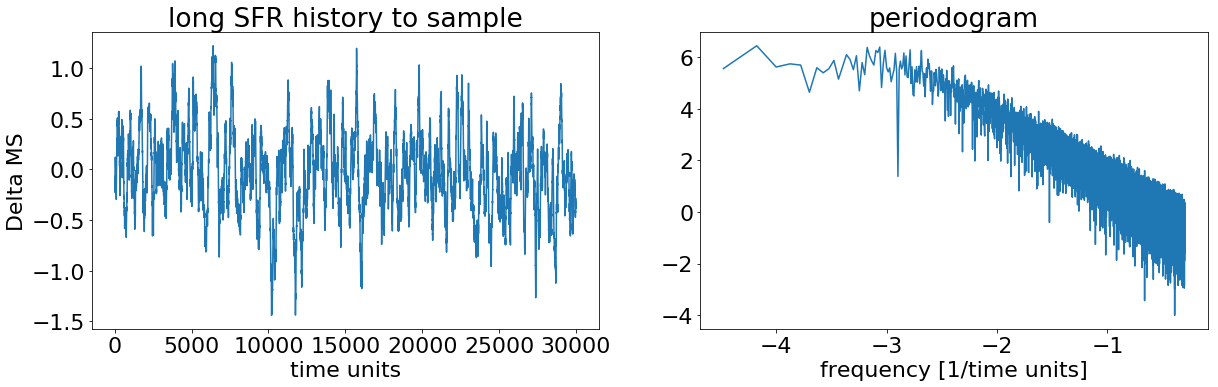

In [90]:
# keep RedNoiseL at least at 10, perhaps 5 if it gets really slow
# Keep aliasTbin=1 

#slope on the short time scales
a_low_Example1=1.5
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend,a_low_Example1,a_high,0),RedNoiseL=10,aliasTbin=1,tbin = 1,length=30000)
#Set scatter of the Main Sequence at 0.4 dex in this example
delc_flux_Example1=0.4*delc.flux

#frequency of the break
a_low_Example2=2
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend,a_low_Example2,a_high,0),RedNoiseL=10,aliasTbin=1,tbin = 1,length=30000)
delc_flux_Example2=0.4*delc.flux

#frequency of the break
a_low_Example3=2.5
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend,a_low_Example3,a_high,0),RedNoiseL=10,aliasTbin=1,tbin = 1,length=30000)
delc_flux_Example3=0.4*delc.flux

# Plot showing created movement around Main Sequence and the periodogram 
plt.figure(figsize=(20,12))
plt.subplot(221)
plt.plot(0.4*delc.flux)
plt.title('long SFR history to sample')
plt.xlabel('time units')
plt.ylabel('Delta MS')

plt.subplot(222)
plt.plot(np.log10(delc.periodogram[0]),np.log10(delc.periodogram[1]))
plt.title('periodogram')
plt.xlabel('frequency [1/time units]')

In [91]:
# We use here 'SFR_Halpha' as SFR measured on shorter time scale
# and 'SFR_UV' as SFR measured on longer time scale
# Tmax = answer to the question: How much longer is 'SFR_UV' then 'SFR_Halpha'?
Tmax=100

#generate 'data'
res_Example1=[]
res_Example2=[]
res_Example3=[]
random_start_positions=np.random.randint(0,30000-Tmax,10000)
for i in range(len(random_start_positions)):
    res_Example1.append([delc_flux_Example1[random_start_positions[i]+Tmax],np.mean(delc_flux_Example1[random_start_positions[i]:random_start_positions[i]+Tmax])])
    res_Example2.append([delc_flux_Example2[random_start_positions[i]+Tmax],np.mean(delc_flux_Example2[random_start_positions[i]:random_start_positions[i]+Tmax])])
    res_Example3.append([delc_flux_Example3[random_start_positions[i]+Tmax],np.mean(delc_flux_Example3[random_start_positions[i]:random_start_positions[i]+Tmax])])
   
res_Example1=np.array(res_Example1)    
res_Example2=np.array(res_Example2)    
res_Example3=np.array(res_Example3)  

In [92]:
# estimate mean relation between 'SFR_UV' and 'SFR_Halpha' from the data

SFR_SFR_Example1=[]
SFR_SFR_Example2=[]
SFR_SFR_Example3=[]
for i in np.arange(-1,1,0.05):
    res_Example1_bin=res_Example1[np.all([res_Example1[:,0]<i+0.05, res_Example1[:,0]>i],axis=0)]
    SFR_SFR_Example1.append([np.mean(res_Example1_bin[:,0]),np.mean(res_Example1_bin[:,1]),np.std(res_Example1_bin[:,1])])
    res_Example2_bin=res_Example2[np.all([res_Example2[:,0]<i+0.05, res_Example2[:,0]>i],axis=0)]
    SFR_SFR_Example2.append([np.mean(res_Example2_bin[:,0]),np.mean(res_Example2_bin[:,1]),np.std(res_Example2_bin[:,1])])
    res_Example3_bin=res_Example3[np.all([res_Example3[:,0]<i+0.05, res_Example3[:,0]>i],axis=0)]
    SFR_SFR_Example3.append([np.mean(res_Example3_bin[:,0]),np.mean(res_Example3_bin[:,1]),np.std(res_Example3_bin[:,1])])
    
SFR_SFR_Example1=np.array(SFR_SFR_Example1)
SFR_SFR_Example2=np.array(SFR_SFR_Example2)
SFR_SFR_Example3=np.array(SFR_SFR_Example3)

In [93]:
# theoretical mean relation between 'SFR_UV' and 'SFR_Halpha'

tau=(1/v_bend)/(2*np.pi)

SFR_UV_Theoretical_Example1=[]
for SFR_Halpha in np.arange(-1,1,0.01):
    SFR_UV_Theoretical_Example1.append([SFR_Halpha,SFR_Halpha*get_mean_relation(tau,a_low_Example1)[Tmax-1][1]])
SFR_UV_Theoretical_Example1=np.array(SFR_UV_Theoretical_Example1)


SFR_UV_Theoretical_Example2=[]
for SFR_Halpha in np.arange(-1,1,0.01):
    SFR_UV_Theoretical_Example2.append([SFR_Halpha,SFR_Halpha*get_mean_relation(tau,a_low_Example2)[Tmax-1][1]])
SFR_UV_Theoretical_Example2=np.array(SFR_UV_Theoretical_Example2)


SFR_UV_Theoretical_Example3=[]
for SFR_Halpha in np.arange(-1,1,0.01):
    SFR_UV_Theoretical_Example3.append([SFR_Halpha,SFR_Halpha*get_mean_relation(tau,a_low_Example3)[Tmax-1][1]])
SFR_UV_Theoretical_Example3=np.array(SFR_UV_Theoretical_Example3)

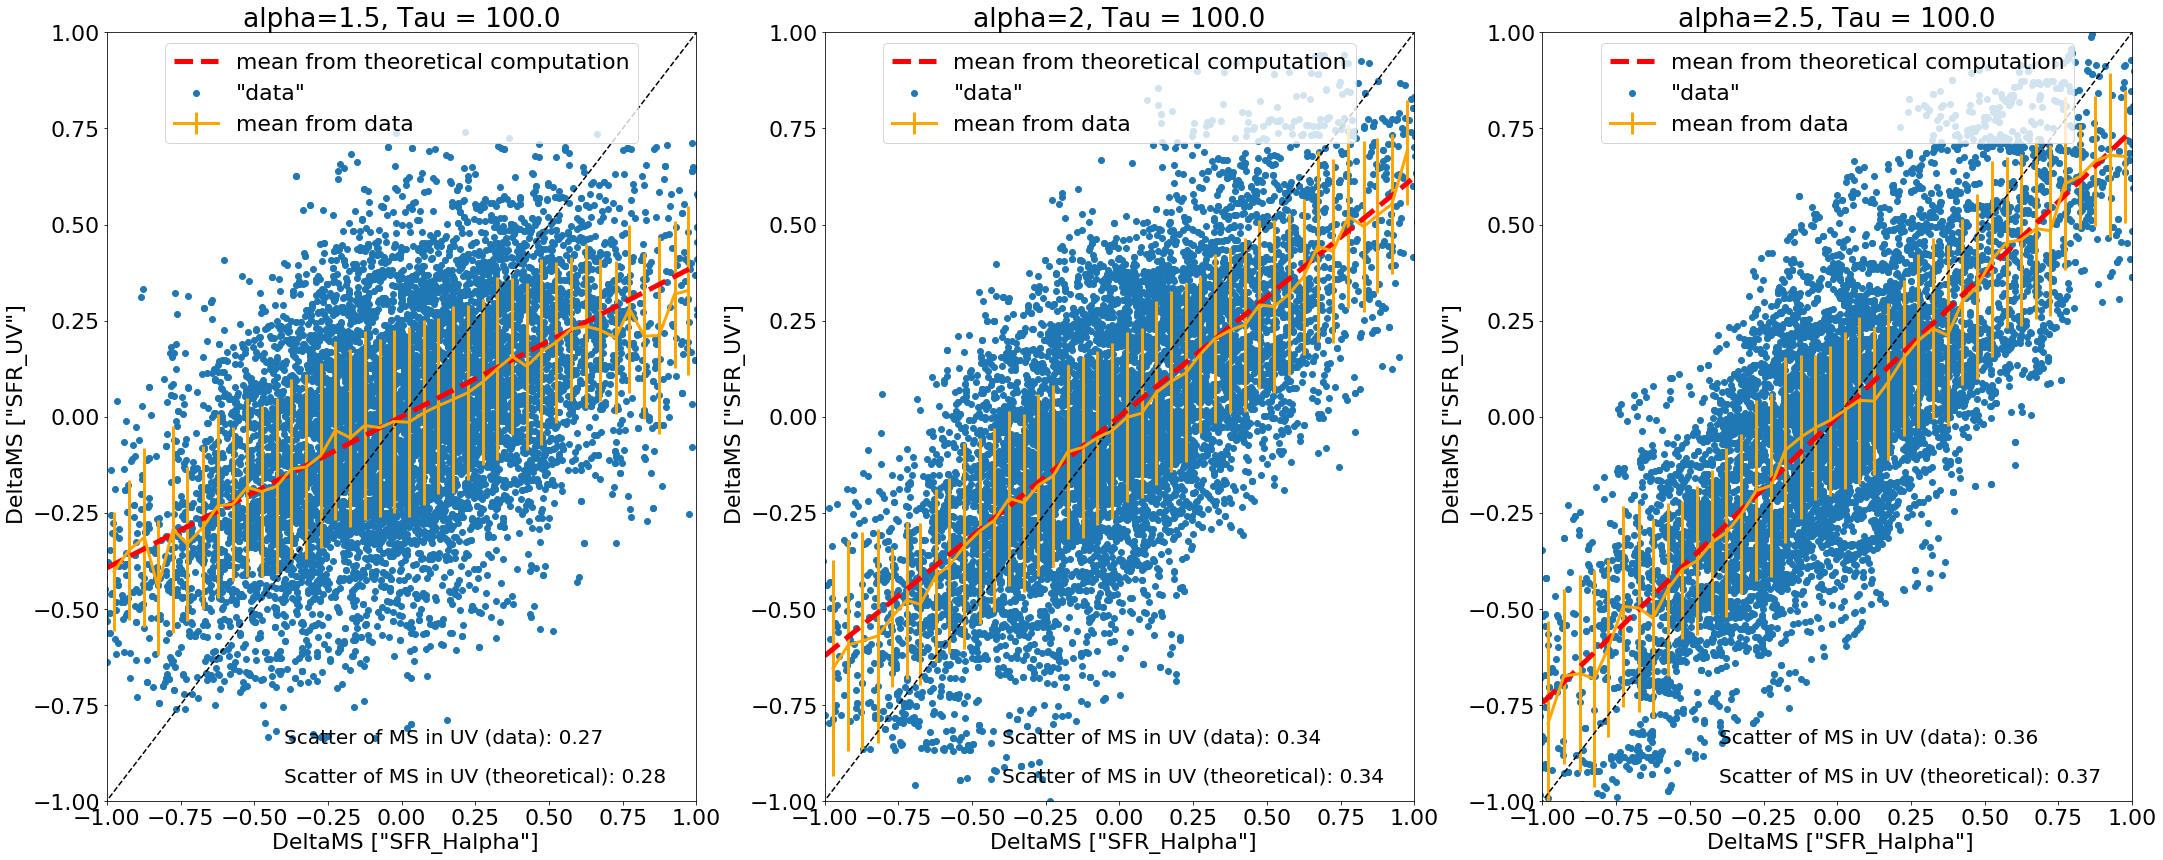

In [94]:
plt.figure(figsize=(30,12))

plt.subplot(1,3,1)
plt.scatter(res_Example1[:,0],res_Example1[:,1],label='"data"')
plt.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')
plt.xlabel(' DeltaMS ["SFR_Halpha"]')
plt.ylabel(' DeltaMS ["SFR_UV"]')
plt.errorbar(SFR_SFR_Example1[:,0],SFR_SFR_Example1[:,1],yerr=SFR_SFR_Example1[:,2],color='orange',lw=3,label='mean from data')
plt.plot(SFR_UV_Theoretical_Example1[:,0],SFR_UV_Theoretical_Example1[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
plt.legend(loc=9)
plt.title("alpha="+str(a_low_Example1)+", Tau = "+str(tau))
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example1[:,1]),2),{'color': 'black', 'fontsize': 20})
plt.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau,a_low_Example1)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})

plt.subplot(1,3,2)
plt.scatter(res_Example2[:,0],res_Example2[:,1],label='"data"')
plt.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')
plt.xlabel(' DeltaMS ["SFR_Halpha"]')
plt.ylabel(' DeltaMS ["SFR_UV"]')
plt.errorbar(SFR_SFR_Example2[:,0],SFR_SFR_Example2[:,1],yerr=SFR_SFR_Example2[:,2],color='orange',lw=3,label='mean from data')
plt.plot(SFR_UV_Theoretical_Example2[:,0],SFR_UV_Theoretical_Example2[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
plt.legend(loc=9)
plt.title("alpha="+str(a_low_Example2)+", Tau = "+str(tau))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example2[:,1]),2),{'color': 'black', 'fontsize': 20})
plt.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau,a_low_Example2)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})

plt.subplot(1,3,3)
plt.scatter(res_Example3[:,0],res_Example3[:,1],label='"data"')
plt.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')
plt.xlabel(' DeltaMS ["SFR_Halpha"]')
plt.ylabel(' DeltaMS ["SFR_UV"]')
plt.errorbar(SFR_SFR_Example3[:,0],SFR_SFR_Example3[:,1],yerr=SFR_SFR_Example3[:,2],color='orange',lw=3,label='mean from data')
plt.plot(SFR_UV_Theoretical_Example3[:,0],SFR_UV_Theoretical_Example3[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
plt.legend(loc=9)
plt.title("alpha="+str(a_low_Example3)+", Tau = "+str(tau))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example3[:,1]),2),{'color': 'black', 'fontsize': 20})
plt.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau,a_low_Example3)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

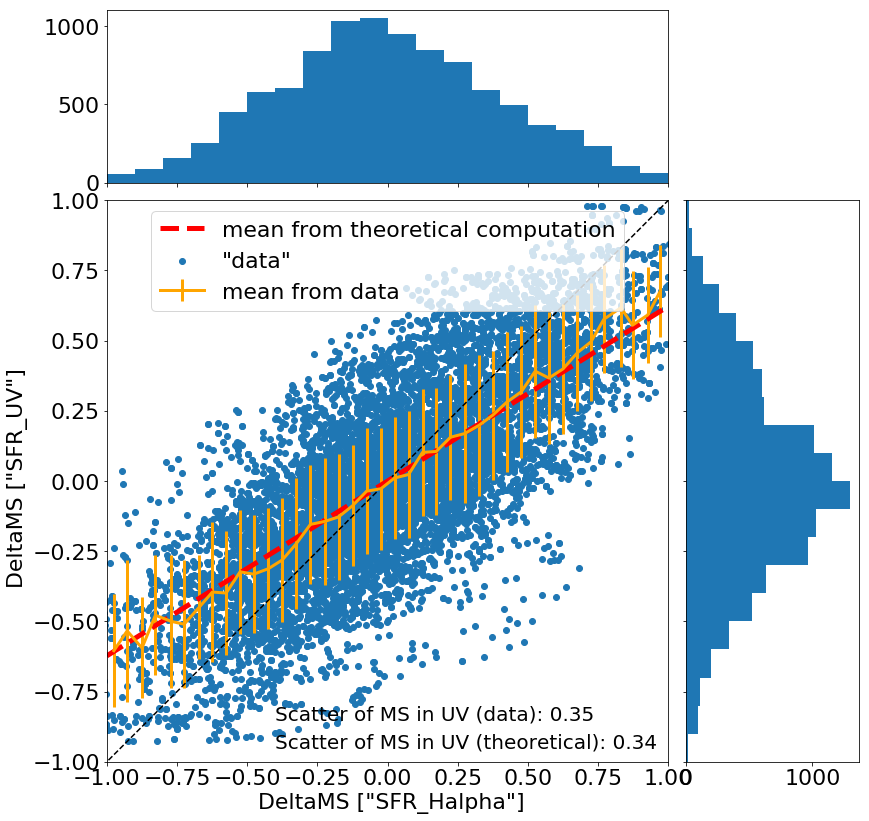

In [115]:
#single plot showing explicity difference in scatter for the middle panel in the Figure above

from matplotlib.ticker import NullFormatter

plt.figure(figsize=(12,12))

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(NullFormatter() )
axHisty.yaxis.set_major_formatter(NullFormatter() )

x=res_Example2[:,0]
y=res_Example2[:,1]

axScatter.scatter(res_Example2[:,0],res_Example2[:,1],label='"data"')
axScatter.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')

axScatter.set_xlabel(' DeltaMS ["SFR_Halpha"]')
axScatter.set_ylabel(' DeltaMS ["SFR_UV"]')
axScatter.errorbar(SFR_SFR_Example2[:,0],SFR_SFR_Example2[:,1],yerr=SFR_SFR_Example2[:,2],color='orange',lw=3,label='mean from data')
axScatter.plot(SFR_UV_Theoretical_Example2[:,0],SFR_UV_Theoretical_Example2[:,1],color='red',ls='--',lw=5,label='mean from theoretical computation')
axScatter.legend(loc='upper center')
#axScatter.title("alpha="+str(a_low)+", Tau = "+str(tau_Example2))
axScatter.set_xlim([-1,1])
axScatter.set_ylim(-1,1)
axScatter.text(-0.4, -0.85,"Scatter of MS in UV (data): "+"%.2f" % round(np.std(res_Example2[:,1]),2),{'color': 'black', 'fontsize': 20})
axScatter.text(-0.4, -0.95,"Scatter of MS in UV (theoretical): "+"%.2f" % round(get_scatter_MS(tau_Example2,a_low)[Tmax-1][1]*0.4,2),{'color': 'black', 'fontsize': 20})


# now determine nice limits by hand:
binwidth = 0.1
xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
lim = (int(xymax/binwidth) + 1) * binwidth


bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(x, bins=bins)
axHisty.hist(y, bins=bins, orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

plt.show()


# Determining slope and time-scale from the data (simple example)

In [11]:
X, Y = np.meshgrid(tau,slope)

Measurment_Of_Scatter_Ratio_1=0.8
err_Measurment_Of_Scatter_Ratio_1=0.08
t_longer_1=20

Measurment_Of_Scatter_Ratio_2=0.60
err_Measurment_Of_Scatter_Ratio_2=0.08
t_longer_2=50

Number_of_sigmas_deviation_1=[]
for plot_slope in tqdm(slope):
    for plot_tau in tau: 
        Number_of_sigmas_deviation_1.append(abs((get_scatter_MS(plot_tau,plot_slope,None,t_longer_1)[1]-Measurment_Of_Scatter_Ratio_1)/err_Measurment_Of_Scatter_Ratio_1))
        
Number_of_sigmas_deviation_1=np.array(Number_of_sigmas_deviation_1)
Number_of_sigmas_deviation_1=Number_of_sigmas_deviation_1.reshape(20,29)

Number_of_sigmas_deviation_2=[]
for plot_slope in tqdm(slope):
    for plot_tau in tau: 
        Number_of_sigmas_deviation_2.append(abs((get_scatter_MS(plot_tau,plot_slope,None,t_longer_2)[1]-Measurment_Of_Scatter_Ratio_2)/err_Measurment_Of_Scatter_Ratio_2))
        
Number_of_sigmas_deviation_2=np.array(Number_of_sigmas_deviation_2)
Number_of_sigmas_deviation_2=Number_of_sigmas_deviation_2.reshape(20,29)

100%|██████████| 20/20 [00:26<00:00,  1.35s/it]


In [12]:
Number_of_sigmas_deviation_reshaped_1=np.copy(Number_of_sigmas_deviation_1)
Number_of_sigmas_deviation_reshaped_1=Number_of_sigmas_deviation_reshaped_1.reshape(len(slope),len(tau))

Number_of_sigmas_deviation_reshaped_2=np.copy(Number_of_sigmas_deviation_2)
Number_of_sigmas_deviation_reshaped_2=Number_of_sigmas_deviation_reshaped_2.reshape(len(slope),len(tau))

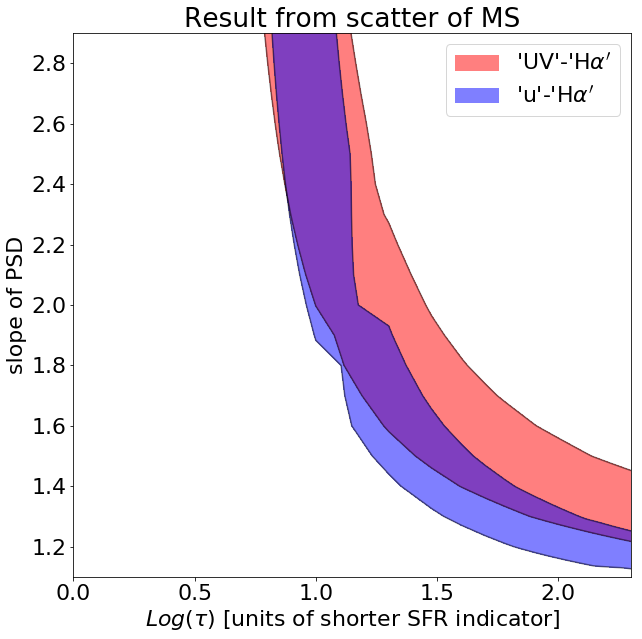

In [21]:
# Basic contour plot
fig, ax = plt.subplots(figsize=(10, 10))
CS = ax.contour(np.log10(X), Y, Number_of_sigmas_deviation_reshaped_1,cmap=plt.cm.bone,levels=[1,5],alpha=0.5)
CS2 = ax.contour(np.log10(X), Y, Number_of_sigmas_deviation_reshaped_2,cmap=plt.cm.bone,levels=[1,5],alpha=0.5)
CS3 = ax.contourf(np.log10(X), Y, Number_of_sigmas_deviation_reshaped_1, [0,1],colors=('r'),alpha=0.5)
CS4 = ax.contourf(np.log10(X), Y, Number_of_sigmas_deviation_reshaped_2, [0,1],colors=('b'),alpha=0.5)

h1,_ = CS3.legend_elements()
h2,_ = CS4.legend_elements()
ax.legend([h1[0], h2[0]], ['\'UV\'-\'H$\\alpha\'$', '\'u\'-\'H$\\alpha\'$'])

# Recast levels to new class
CS.levels = [1,1.5]
CS3.levels = [1,1.5]
# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r \sigma %'
else:
    fmt = '%r $\sigma$'

#ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
#ax.clabel(CS3, CS3.levels, inline=True, fmt=fmt, fontsize=10)
ax.set_ylim(1.1,2.9)
#ax.legend()
ax.set_title('Result from scatter of MS')
ax.set_xlabel('$Log(\\tau)$ [units of shorter SFR indicator]')
ax.set_ylabel('slope of PSD')

# Future work  - relations between longer and shorter timescales with weights

If $ \Delta SFR_{longer}= \frac{\sum^{N}_{j=1} w_{j} \Delta SFR_{shorter} }{\sum^{N}_{j=1}  w_{j}}  $  instead of simplest case above: $ \Delta SFR_{longer}= \frac{\sum^{N}_{j=1}\Delta SFR_{shorter} }{N}  $  

Scatter of MS at longer scales with weights $w_{j}$:
$ \sigma^{2}_{longer}= \frac{\sigma^{2}_{shorter}}{N^{2}_{j}}\sum^{N_{j}}_{j=1} \sum^{N_{j}}_{j^{'}=1} w_{j}w_{j^{'}} ACF(j-j^{'}) $

Offset of MS at longer scales given the offset at shorter time scales:with weights $w_{j}$: $ \Delta SFR_{longer}=\Delta SFR_{shorter} \cdot \frac{\sum^{N}_{j=1} w_{j} ACF(j)}{\sum^{N}_{j=1}  w_{j}}  $  